In [1]:
# import pandas as pd
# import time
# import csv
# import numpy as np
# import os
# from sklearn.metrics import log_loss, mean_squared_error
# from sklearn.linear_model import SGDClassifier, LassoCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sknn.mlp import Classifier, Layer
# from sklearn.metrics import explained_variance_score, accuracy_score
# from sklearn.model_selection import KFold, cross_val_score

import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt

#Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Models

from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression, SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
# from sklearn.lda import LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
# from xgboost import XGBClassifier
from sknn.mlp import Classifier, Layer

#Check accuracy
from sklearn.metrics import accuracy_score, log_loss, explained_variance_score, mean_squared_error

#Model selection
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\maitreyi_kv\appdata\local\programs\python\python36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\users\maitreyi_kv\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which a

In [2]:
features = ['hour', 'day', 'dow', 'C1', 'banner_pos', 'device_type', 'device_conn_type',
            'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'site_id', 'site_domain',
            'site_category', 'app_id', 'app_domain', 'app_category', 'device_model',
            'device_id', 'device_ip']

# Load data

train = pd.read_csv('data/train-100000R.csv', dtype={'id':pd.np.string_}, nrows=1000)
test = pd.read_csv('data/test-100000R.csv', dtype={'id':pd.np.string_}, nrows=1000)

train.shape, test.shape

((1000, 24), (1000, 24))

In [3]:
# Not only to check what is numeric, also to see which features can be normalized
original_num_values = train.select_dtypes(exclude='object').columns

# Columns categorical - Train

train[train.columns[-8:]] = train[train.columns[-8:]].astype('object')
train[['C1', 'device_type']] = train[['C1', 'device_type']].astype('object')
train.select_dtypes(include='object').columns

# Test
test[test.columns[-8:]] = test[test.columns[-8:]].astype('object')
test[['C1', 'device_type']] = test[['C1', 'device_type']].astype('object')
test.select_dtypes(include='object').columns

categorical_columns = train.select_dtypes(include='object').columns

# Numeric values
numeric_columns = train.select_dtypes(exclude='object').columns
categorical_columns, numeric_columns
#TODO : Come back to this, figure out if these values are numeric or categorical!

(Index(['id', 'C1', 'site_id', 'site_domain', 'site_category', 'app_id',
        'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',
        'device_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
       dtype='object'),
 Index(['click', 'hour', 'banner_pos', 'device_conn_type'], dtype='object'))

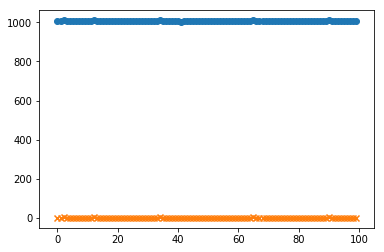

In [4]:
# some numerical and some categorical -> But classifiers take only numeric values -> Encode them
plt.scatter(list(range(100)), train['C1'][:100], marker='o')
le = LabelEncoder()
for col in categorical_columns:
    le.fit(list(train[col]) + list(test[col]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

train.shape, test.shape

plt.scatter(list(range(100)), train['C1'][:100], marker='x')

c:\users\maitreyi_kv\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


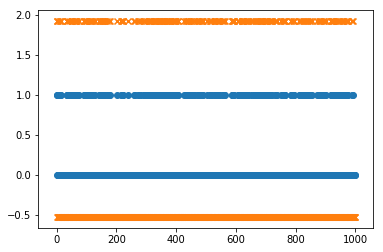

In [5]:
# Stochastic Gradient Descent is sensitive to feature scaling, so it is highly recommended to scale your data.
plt.scatter(list(range(train.shape[0])), train['banner_pos'][:train.shape[0]], marker='o')
# plt.scatter(list(range(100)), train['banner_pos'][:100])
scaler = StandardScaler()
for col in ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']:
    ch = np.hstack([train[col], test[col]]).reshape(-1, 1)
#     print(ch.shape,'\n================\n', ch[:10], '\n================\n', ch_reshape.shape, '\n',ch_reshape[:10])
    scaler.fit(ch)
    train[col] = scaler.transform(train[col].values.reshape(-1, 1))
    test[col] = scaler.transform(test[col].values.reshape(-1, 1))
    
train.shape, test.shape, train.columns

plt.scatter(list(range(train.shape[0])), train['banner_pos'][:train.shape[0]], marker='x')

In [6]:
# Add new features:
train['day'] = train['hour'].apply(lambda x: (x - x % 10000) / 1000000)  # day
train['dow'] = train['hour'].apply(lambda x: ((x - x % 10000) / 1000000) % 7)  # day of week
train['hour'] = train['hour'].apply(lambda x: x % 10000 / 100)  # hour
 
test['day'] = test['hour'].apply(lambda x: (x - x % 10000) / 1000000)  # day
test['dow'] = test['hour'].apply(lambda x: ((x - x % 10000) / 1000000) % 7)  # day of week
test['hour'] = test['hour'].apply(lambda x: x % 10000 / 100)  # hour

train.shape, test.shape, type(train), type(test)

((1000, 26),
 (1000, 26),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [7]:
train.shape, test.shape

((1000, 26), (1000, 26))

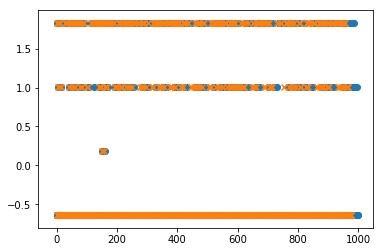

In [8]:
plt.scatter(list(range(train.shape[0])), train['C18'][:train.shape[0]], marker='o')


# Remove outliner
for col in ['C18', 'C20', 'C21']:
    # keep only the ones that are within +3 to -3 standard deviations in the column col,
    train = train[np.abs(train[col] - train[col].mean()) <= (3 * train[col].std())]
       
train.shape, test.shape

plt.scatter(list(range(train.shape[0])), train['C18'][:train.shape[0]], marker='x')

In [12]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
param_knn = {'n_neighbors' : np.arange(1, 300, 2) }

In [13]:
# Define classifiers

classifiers = [
    GridSearchCV(KNeighborsClassifier(), param_knn),
    KNeighborsClassifier(n_neighbors=100, weights='uniform', leaf_size=100, p=2),
    RandomizedSearchCV(KNeighborsClassifier(), param_knn),
    GridSearchCV(SVC(probability=True), param_grid),
    RandomizedSearchCV(SVC(probability=True), param_grid),
    LogisticRegression(random_state=0),
    LinearDiscriminantAnalysis(n_components=2),
    GaussianNB(),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    SGDClassifier(loss='log', n_iter=30, verbose=5, learning_rate='invscaling', eta0=0.0000000001), #'invscaling'
#     Classifier(
#         layers=[
# #             Layer('Rectifier', units=100),
#             Layer("Softmax")],
#         learning_rate=0.0001000,
#         learning_rule='momentum',
#         learning_momentum=0.9,
#         batch_size=25,
#         valid_size=0.1,
#         # valid_set=(X_test, y_test),
#         n_stable=10,
#         n_iter=10,
#         verbose=True),
    ExtraTreesClassifier(n_estimators=100),
    RandomForestClassifier(n_estimators=100),
    
    
#         TODO : https://github.com/dmlc/xgboost/issues/2334
#         XGBClassifier(n_estimators=512, max_depth=4),
]

classifiers    

[GridSearchCV(cv=None, error_score='raise',
        estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'n_neighbors': array([  1,   3, ..., 297, 299])},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0),
 KNeighborsClassifier(algorithm='auto', leaf_size=100, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=100, p=2,
            weights='uniform'),
 RandomizedSearchCV(cv=None, error_score='raise',
           estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
           fit_params=None, iid=True, n_iter=10, n_jobs=1,
           param_distributions={'n_neighbors': array([  1,   3, ..., 297, 299])},


In [14]:
# Train - kfold diverging for NN
time_taken = []
k_fold_splits = 2
cv_score = np.array((len(classifiers), k_fold_splits))

for classifier in classifiers:
    print("=====================================================================================================")
    start = time.time()
    
    k_fold = KFold(n_splits=k_fold_splits)
    for X_train_idx, X_test_idx in k_fold.split(train):
        classifier.fit(train[features], train.click).score(train[features], train.click)
    
    cvs = cross_val_score(classifier, train[features], train.click, cv=k_fold, n_jobs=-1) #all cpu's
    cv_score = np.vstack((cv_score, cvs))

    time_taken.append(time.time() - start)
    
    if classifier.__class__.__name__ in ['GridSearchCV', 'RandomizedSearchCV']:
        print('Best param for SVC {} :'.format(classifier.best_params_))
        
    print("cv score", cv_score)
    print('{} \n -> Training time: {}'.format(classifier.__class__.__name__, time.time() - start))
    print("=====================================================================================================")
    
    
time_taken

Best param for SVC {'n_neighbors': 13} :
cv score [[13.          2.        ]
 [ 0.82208589  0.83640082]]
GridSearchCV 
 -> Training time: 47.78877854347229
cv score [[13.          2.        ]
 [ 0.82208589  0.83640082]
 [ 0.82413088  0.83640082]]
KNeighborsClassifier 
 -> Training time: 3.524352550506592
Best param for SVC {'n_neighbors': 267} :
cv score [[13.          2.        ]
 [ 0.82208589  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.82413088  0.83640082]]
RandomizedSearchCV 
 -> Training time: 6.3366334438323975
Best param for SVC {'C': 10, 'gamma': 0.1} :
cv score [[13.          2.        ]
 [ 0.82208589  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.8200409   0.83640082]]
GridSearchCV 
 -> Training time: 34.50144982337952
Best param for SVC {'gamma': 1, 'C': 0.001} :
cv score [[13.          2.        ]
 [ 0.82208589  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.8200409   0.83640082]
 [ 0.82413088  0.83640082]]
RandomizedSearchC

c:\users\maitreyi_kv\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


cv score [[13.          2.        ]
 [ 0.82208589  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.8200409   0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.81799591  0.8200409 ]
 [ 0.82413088  0.81390593]]
LinearDiscriminantAnalysis 
 -> Training time: 3.7743775844573975
cv score [[13.          2.        ]
 [ 0.82208589  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.8200409   0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.81799591  0.8200409 ]
 [ 0.82413088  0.81390593]
 [ 0.60531697  0.50715746]]
GaussianNB 
 -> Training time: 3.4813480377197266
cv score [[13.          2.        ]
 [ 0.82208589  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.8200409   0.83640082]
 [ 0.82413088  0.83640082]
 [ 0.81799591  0.8200409 ]
 [ 0.82413088  0.81390593]
 [ 0.60531697  0.50715746]
 [ 0.74642127  0.71574642]]
DecisionTreeClassifier 
 -> Training time: 4.036403656005859
cv score [[13.          2.        ]
 [ 0.82208589  0.83640082]
 

c:\users\maitreyi_kv\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


-- Epoch 1
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 978, Avg. loss: 0.692712
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 1956, Avg. loss: 0.692360
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 2934, Avg. loss: 0.692133
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 3912, Avg. loss: 0.691951
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 4890, Avg. loss: 0.691793
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 5868, Avg. loss: 0.691652
Total training time: 0.05 seconds.
-- Epoch 7
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 6846, Avg. loss: 0.691524
Total training time: 0.06 seconds.
-- Epoch 8
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 7824, Avg. loss: 0.691405
Total training time: 0.08 seconds.
-- Epoch 9
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 8802, Avg. loss: 0.691294
Total trai

c:\users\maitreyi_kv\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


-- Epoch 1
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 978, Avg. loss: 0.692711
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 1956, Avg. loss: 0.692359
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 2934, Avg. loss: 0.692132
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 3912, Avg. loss: 0.691949
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 4890, Avg. loss: 0.691792
Total training time: 0.04 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 5868, Avg. loss: 0.691651
Total training time: 0.05 seconds.
-- Epoch 7
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 6846, Avg. loss: 0.691522
Total training time: 0.06 seconds.
-- Epoch 8
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 7824, Avg. loss: 0.691403
Total training time: 0.06 seconds.
-- Epoch 9
Norm: 0.00, NNZs: 24, Bias: -0.000000, T: 8802, Avg. loss: 0.691292
Total trai

[47.7757773399353,
 3.5103511810302734,
 6.326632738113403,
 34.492448806762695,
 18.759876012802124,
 3.757375478744507,
 3.764376401901245,
 3.466346502304077,
 4.030403137207031,
 3.915391445159912,
 5.162516117095947,
 4.17541766166687,
 4.120412111282349]

In [15]:
# Evaluation 

log_losses = []
rmse_loss = []
accuracy = []
y_expected = test.click.values

print('{:<26} | {:<25} | {:<25} | {:>10} | {}'.format('Classifier', 'Log loss', 'Rmse loss', 'Accuracy', 'Time'))
print('----------------------------------------------------------------------------------------------------')
for idx, classifier in enumerate(classifiers):
    if classifier.__class__.__name__ != 'LassoCV':
        y_predicted = classifier.predict_proba(test[features])
        accu_score = accuracy_score(y_expected, classifier.predict(test[features]))
    log_loss_class = log_loss(y_expected, y_predicted)
    rmse_loss_class = mean_squared_error(y_expected, np.compress([False, True], y_predicted, axis=1))**0.5
    
    
    log_losses.append(log_loss_class)
    rmse_loss.append(rmse_loss_class)
    accuracy.append(accu_score)

    print('{:<26} | {:<25} | {:<25} | {:>10} | {}'.format(classifier.__class__.__name__, log_loss_class, rmse_loss_class, accu_score, time_taken[idx]))


Classifier                 | Log loss                  | Rmse loss                 |   Accuracy | Time
----------------------------------------------------------------------------------------------------
GridSearchCV               | 1.0789461661250206        | 0.38721429627869314       |      0.829 | 47.7757773399353
KNeighborsClassifier       | 0.4586071157120941        | 0.375980983561669         |      0.832 | 3.5103511810302734
RandomizedSearchCV         | 0.45299863958242886       | 0.37402548168419564       |      0.832 | 6.326632738113403
GridSearchCV               | 0.4544365866798705        | 0.37489541916368024       |      0.826 | 34.492448806762695
RandomizedSearchCV         | 0.4528886352236307        | 0.37421795320416723       |      0.832 | 18.759876012802124
LogisticRegression         | 0.4407604246080951        | 0.36596121942216525       |      0.831 | 3.757375478744507
LinearDiscriminantAnalysis | 0.5635297010442186        | 0.38713595167499365       |      0.831 | 

In [16]:
print("Best")
print('Log loss (Lowest)\n ', classifiers[log_losses.index(min(log_losses))])
print('Rmse (Lowest) \n ', classifiers[rmse_loss.index(min(rmse_loss))])
print('Accuracy (Highest)\n', classifiers[accuracy.index(max(accuracy))])
print('Time (Least)\n', classifiers[time_taken.index(min(time_taken))])

Best
Log loss (Lowest)
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Rmse (Lowest) 
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Highest)
 KNeighborsClassifier(algorithm='auto', leaf_size=100, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')
Time (Least)
 GaussianNB(priors=None)


In [17]:
classifi = ()
for clf in classifiers:
    classifi += (clf.__class__.__name__ ,) 
    
classifi

('GridSearchCV',
 'KNeighborsClassifier',
 'RandomizedSearchCV',
 'GridSearchCV',
 'RandomizedSearchCV',
 'LogisticRegression',
 'LinearDiscriminantAnalysis',
 'GaussianNB',
 'DecisionTreeClassifier',
 'GradientBoostingClassifier',
 'SGDClassifier',
 'ExtraTreesClassifier',
 'RandomForestClassifier')

([<matplotlib.axis.XTick at 0x15211278>,
 <a list of 13 Text xticklabel objects>)

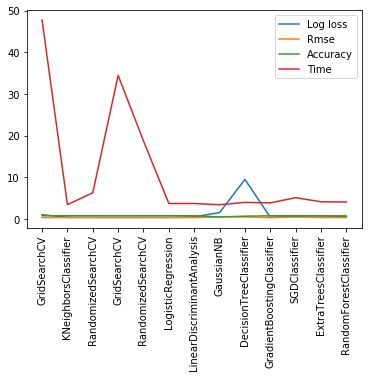

In [18]:
range_x = range(len(log_losses))

plt.plot(range_x, log_losses, label='Log loss')
plt.plot(range_x, rmse_loss, label='Rmse')
plt.plot(range_x, accuracy, label='Accuracy')
plt.plot(range_x, time_taken, label='Time')

plt.legend(loc='best')
plt.xticks(range(len(log_losses)), classifi, rotation='vertical')

#TODO: 
# 1. Grid search 
# 2. Plot this to see time vs accuracy vs error
# 3. nn and sgd parameter
# 4. Integrate the feature selection part - choose best feat
# 5. Visualize teh knn clustering - kmapper

([<matplotlib.axis.XTick at 0x55440f0>,
 <a list of 13 Text xticklabel objects>)

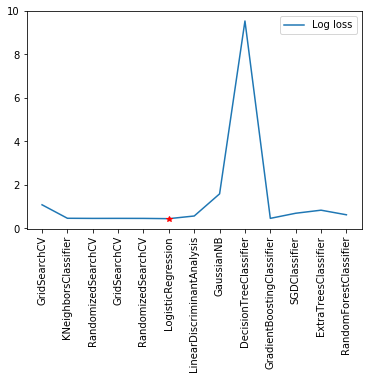

In [19]:
plt.plot(range_x, log_losses, label='Log loss')
plt.plot(range_x[log_losses.index(min(log_losses))] , min(log_losses), 'r*')

plt.legend(loc='best')
plt.xticks(range(len(log_losses)), classifi, rotation='vertical')

([<matplotlib.axis.XTick at 0x55aa780>,
 <a list of 13 Text xticklabel objects>)

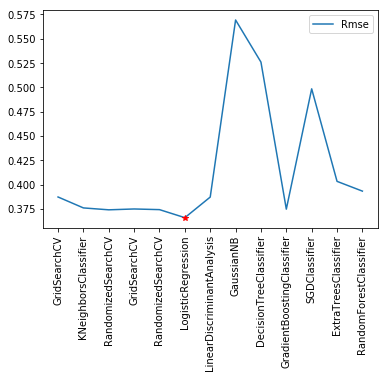

In [20]:
plt.plot(range_x, rmse_loss, label='Rmse')
plt.plot(range_x[rmse_loss.index(min(rmse_loss))] , min(rmse_loss), 'r*')
locs, labels = plt.xticks()

plt.legend(loc='best')
plt.xticks(range(len(rmse_loss)), classifi, rotation='vertical')

([<matplotlib.axis.XTick at 0x56221d0>,
 <a list of 13 Text xticklabel objects>)

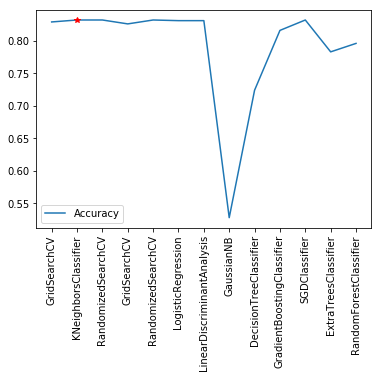

In [21]:
plt.plot(range_x, accuracy, label='Accuracy')
plt.plot(range_x[accuracy.index(max(accuracy))] , max(accuracy), 'r*')
locs, labels = plt.xticks()

plt.legend(loc='best')
plt.xticks(range(len(log_losses)), classifi, rotation='vertical')

([<matplotlib.axis.XTick at 0x568dcc0>,
 <a list of 13 Text xticklabel objects>)

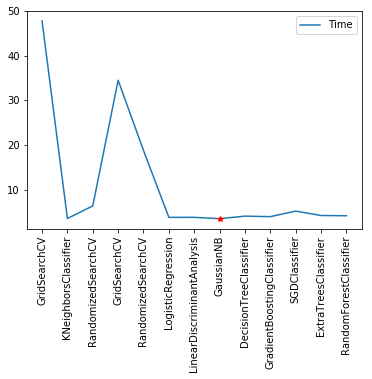

In [22]:
plt.plot(range_x, time_taken, label='Time')
plt.plot(range_x[time_taken.index(min(time_taken))] , min(time_taken), 'r*')
locs, labels = plt.xticks()

plt.legend(loc='best')
plt.xticks(range(len(time_taken)), classifi, rotation='vertical')